Leandro Coelho <br>
BeeData<br>
Desafio Constelation <hr>
22/07/2023
<br>
Modelo Benchmark
<br>
Objetivo:
- ter uma baseline a superar
- supor que é como o mercado lida com o problema hoje

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller

pd.set_option('display.max_columns', None)

In [25]:
d01 = pd.read_csv("https://raw.githubusercontent.com/LeandroCoelhos/BeeData/main/Desafio_Constellation/train_01.csv")
d02 = pd.read_csv("https://raw.githubusercontent.com/LeandroCoelhos/BeeData/main/Desafio_Constellation/train_02.csv")
d03 = pd.read_csv("https://raw.githubusercontent.com/LeandroCoelhos/BeeData/main/Desafio_Constellation/train_03.csv")
d04 = pd.read_csv("https://raw.githubusercontent.com/LeandroCoelhos/BeeData/main/Desafio_Constellation/train_04.csv")
d05 = pd.read_csv("https://raw.githubusercontent.com/LeandroCoelhos/BeeData/main/Desafio_Constellation/train_05.csv")
train = pd.concat([d01,d02,d03,d04,d05], axis=0)
train.id.value_counts()

0          1
2000584    1
2000586    1
2000587    1
2000588    1
          ..
1000298    1
1000299    1
1000300    1
1000301    1
3000887    1
Name: id, Length: 3000888, dtype: int64

In [26]:
del d01,d02, d03, d04, d05

# Transformar os tipos iniciais

In [27]:
def transformar_data(df,coluna):
  df[coluna] = pd.to_datetime(df[coluna])
  df[coluna] = df.date.dt.to_period('D')
  return df

def transformar_categoria(df, coluna):
  df[coluna] = df[coluna].astype('str').astype('category')
  return df

def preencher_calendario(df):
# Dicionário de mapeamento dos nomes dos dias da semana de inglês para português
  dias_da_semana_map = {
      'Monday': 'Segunda-feira',
      'Tuesday': 'Terça-feira',
      'Wednesday': 'Quarta-feira',
      'Thursday': 'Quinta-feira',
      'Friday': 'Sexta-feira',
      'Saturday': 'Sábado',
      'Sunday': 'Domingo'
  }
  df['dia_da_semana'] = df['date'].dt.strftime('%A').map(dias_da_semana_map)
  df['ano'] = df.date.dt.year
  df['mes'] = df.date.dt.month
  df['dia'] = df.date.dt.day
  return df

In [28]:
# Treino
train = transformar_data(train, 'date')
train = transformar_categoria(train, 'family')
train = transformar_categoria(train, 'store_nbr')
train = preencher_calendario(train)

In [29]:
train.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000888 entries, 0 to 600486
Data columns (total 10 columns):
 #   Column         Non-Null Count    Dtype    
---  ------         --------------    -----    
 0   id             3000888 non-null  int64    
 1   date           3000888 non-null  period[D]
 2   store_nbr      3000888 non-null  category 
 3   family         3000888 non-null  category 
 4   sales          3000888 non-null  float64  
 5   onpromotion    3000888 non-null  int64    
 6   dia_da_semana  3000888 non-null  object   
 7   ano            3000888 non-null  int64    
 8   mes            3000888 non-null  int64    
 9   dia            3000888 non-null  int64    
dtypes: category(2), float64(1), int64(5), object(1), period[D](1)
memory usage: 211.8+ MB


In [30]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,dia_da_semana,ano,mes,dia
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Terça-feira,2013,1,1
1,1,2013-01-01,1,BABY CARE,0.0,0,Terça-feira,2013,1,1
2,2,2013-01-01,1,BEAUTY,0.0,0,Terça-feira,2013,1,1
3,3,2013-01-01,1,BEVERAGES,0.0,0,Terça-feira,2013,1,1
4,4,2013-01-01,1,BOOKS,0.0,0,Terça-feira,2013,1,1


# Separação em treino, validação e Teste

In [31]:
treino = train[(train.date <= '2017-05-31')]
validacao = train[(train.ano == 2017) & (train.mes == 6)]
teste = train[(train.ano == 2017) & (train.mes == 7)]
treino.shape, validacao.shape,teste.shape

((2865456, 10), (53460, 10), (55242, 10))

<Axes: xlabel='date'>

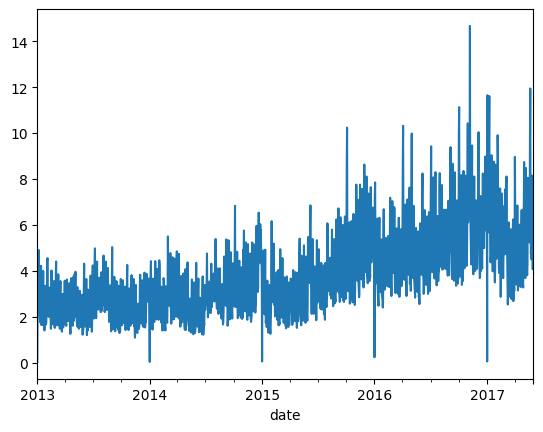

In [32]:
sales_by_family = treino.groupby(['family', 'date']).sales.mean().unstack('family')
sales_by_family['BEAUTY'].plot()

In [33]:
results = {}
count = 0
for col in sales_by_family.columns:
    results[col] = adfuller(sales_by_family[col], regression='ctt')
    critical_values = results[col][4]
    p_value = results[col][1]
    t_stat = results[col][0]

    if critical_values['1%'] < t_stat:
        print(col,"|", f"T-Statistic: {t_stat:.3f}","|", f"Critical 1% value: {critical_values['1%']:.3f}","|",  f"P-Value: {p_value:.3f}")
        count += 1
f"{(1 - count/len(sales_by_family.columns)) * 100:.2f}% of the series are stationary at the 1% level"

BABY CARE | T-Statistic: -3.943 | Critical 1% value: -4.378 | P-Value: 0.037
BOOKS | T-Statistic: -3.682 | Critical 1% value: -4.378 | P-Value: 0.074
DAIRY | T-Statistic: -3.741 | Critical 1% value: -4.378 | P-Value: 0.063
EGGS | T-Statistic: -3.997 | Critical 1% value: -4.378 | P-Value: 0.032
LAWN AND GARDEN | T-Statistic: -2.945 | Critical 1% value: -4.378 | P-Value: 0.322
MAGAZINES | T-Statistic: -3.883 | Critical 1% value: -4.378 | P-Value: 0.044
POULTRY | T-Statistic: -3.396 | Critical 1% value: -4.378 | P-Value: 0.142


'78.79% of the series are stationary at the 1% level'

In [34]:
sorted([x[1] for x in results.values()], reverse=True)[:5]

[0.32203025825025233,
 0.14153090627157505,
 0.07364658884557221,
 0.06344786771604723,
 0.04369289436645678]

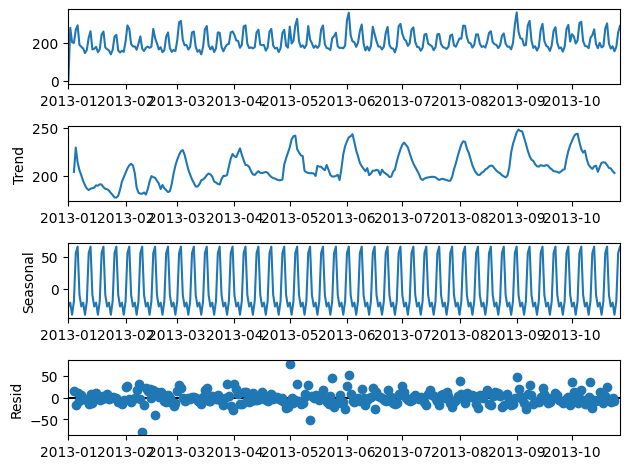

In [35]:
# Identifying components of a time series
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

average_sales = sales_by_family.mean(axis=1)
average_sales.index = average_sales.index.to_timestamp()
seasonal_decompose(average_sales.iloc[:300], period=7).plot();

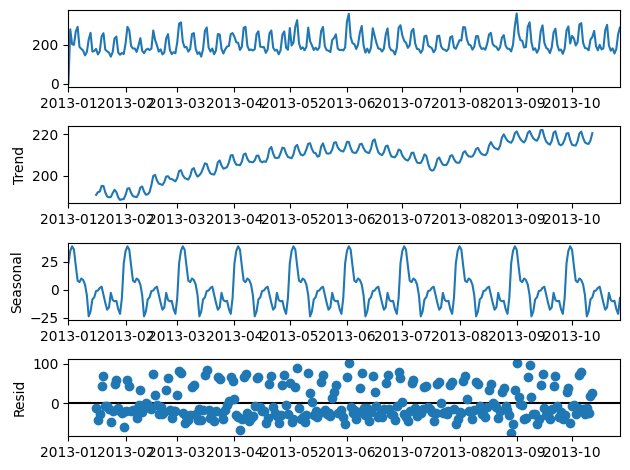

In [36]:
seasonal_decompose(average_sales.iloc[:300], period=30).plot();

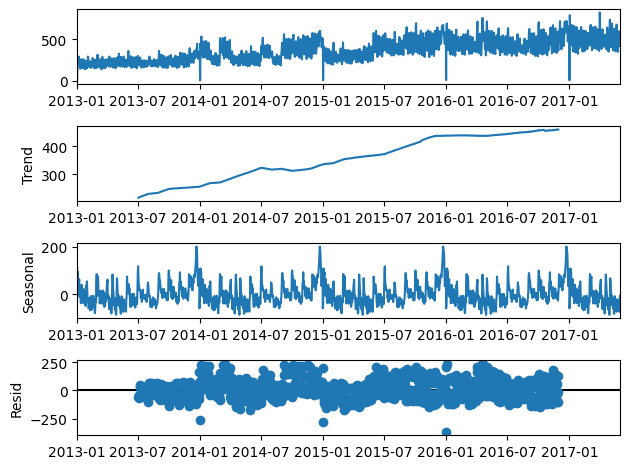

In [37]:
seasonal_decompose(average_sales, period=365).plot();

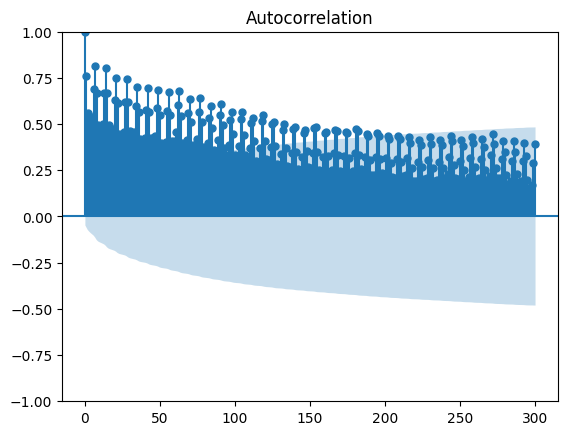

In [38]:
plot_acf(average_sales, lags=300);

In [71]:
# Constructing prediction series
y_treino = treino.set_index(['date', 'store_nbr', 'family']).sales.unstack(['store_nbr', 'family'])
X_treino = pd.DataFrame(pd.Series(np.arange(len(y)) + 1,index=y.index), columns=['t'])

In [58]:
y_validacao = validacao.set_index(['date', 'store_nbr', 'family']).sales.unstack(['store_nbr', 'family'])
y_teste = teste.set_index(['date', 'store_nbr', 'family']).sales.unstack(['store_nbr', 'family'])

In [68]:
X.tail(2)

,t
date,
2017-05-30,1607
2017-05-31,1608


In [69]:
X_validacao = pd.DataFrame( pd.Series(np.arange(len(y), len(y) + len(y_validacao)) + 1,index=y_validacao.index), columns=['t'])
X_validacao.tail(2)

,t
date,
2017-06-29,1637
2017-06-30,1638


In [70]:
X_teste = pd.DataFrame( pd.Series(np.arange(len(y) + len(y_validacao) , len(y) + len(y_validacao) + len(y_teste)) + 1,index=y_teste.index), columns=['t'])
X_teste.tail(2)

,t
date,
2017-07-30,1668
2017-07-31,1669


In [72]:
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error

def fit_predict():
    model = LinearRegression(fit_intercept=False)
    model.fit(X_treino, y_treino)
    pred = pd.DataFrame(model.predict(X_validacao), columns=y_validacao.columns, index=y_validacao.index)
    return pred

pred = fit_predict()

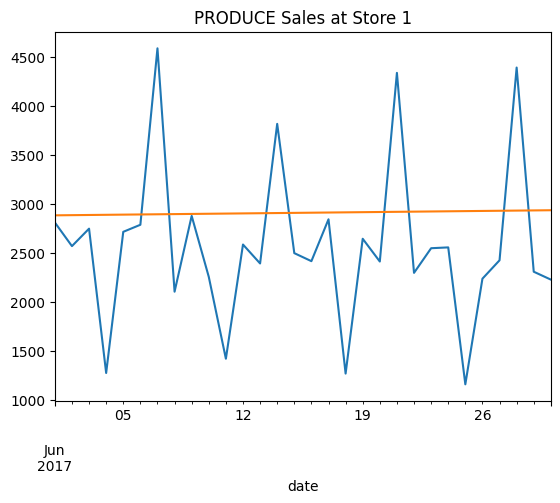

In [73]:
def plot(store_number, family):
    ax = y_validacao[(store_number, family)].plot()
    ax = pred[(store_number, family)].plot(ax=ax)
    ax.set_title(f'{family} Sales at Store {store_number}')
plot('1', 'PRODUCE')

In [74]:
def mse(pred):
    return mean_squared_error(y_validacao, pred, squared=False)
mse(pred)

229.21880260426894

In [77]:
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarSeasonality

week = CalendarSeasonality('D', 'W').in_sample(sales_by_family.index)
week

,"s(D=1, period=W)","s(D=2, period=W)","s(D=3, period=W)","s(D=4, period=W)","s(D=5, period=W)","s(D=6, period=W)","s(D=7, period=W)"
date,,,,,,,
2013-01-01,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2013-01-02,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2013-01-03,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2013-01-04,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2013-01-05,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...
2017-05-27,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2017-05-28,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2017-05-29,1.0,0.0,0.0,0.0,0.0,0.0,0.0
